# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


In [4]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Признаки**  
* DateCrawled — дата скачивания анкеты из базы  
* VehicleType — тип автомобильного кузова  
* RegistrationYear — год регистрации автомобиля  
* Gearbox — тип коробки передач  
* Power — мощность (л. с.)  
* Model — модель автомобиля  
* Kilometer — пробег (км)  
* RegistrationMonth — месяц регистрации автомобиля  
* FuelType — тип топлива  
* Brand — марка автомобиля  
* NotRepaired — была машина в ремонте или нет  
* DateCreated — дата создания анкеты  
* NumberOfPictures — количество фотографий автомобиля  
* PostalCode — почтовый индекс владельца анкеты (пользователя)  
* LastSeen — дата последней активности пользователя  

**Целевой признак**  
* Price — цена (евро)  
Прпуски замечены в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired.  
В некоторых столбцах замечены явно неподходящие значения на максимуме - выбросы.

<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка и первичный осмотр данных проведены хорошо.
</div>

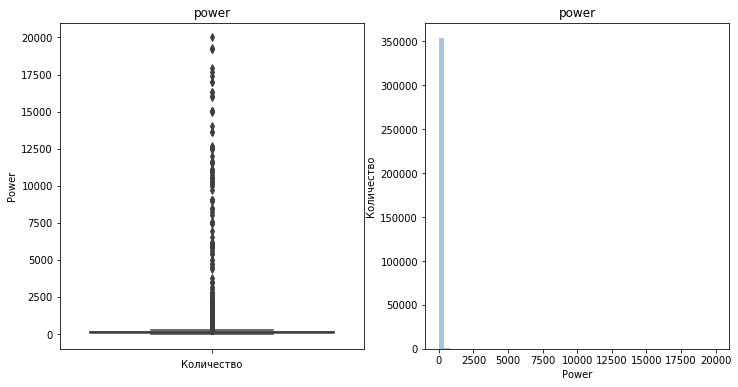

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('power')
sns.boxplot(y = 'Power', data=data, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('power')
sns.distplot(data['Power'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')
            
plt.show()


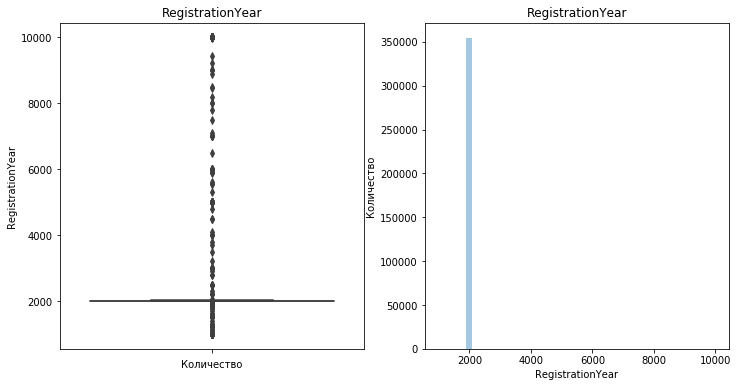

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('RegistrationYear')
sns.boxplot(y = 'RegistrationYear', data=data, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('RegistrationYear')
sns.distplot(data['RegistrationYear'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')
            
plt.show()

Text(0, 0.5, 'Количество')

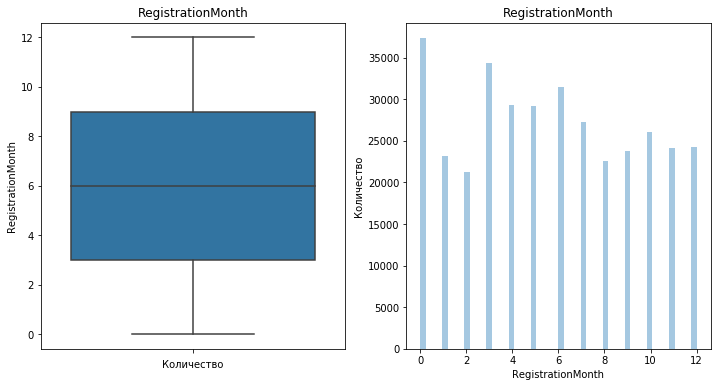

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('RegistrationMonth')
sns.boxplot(y = 'RegistrationMonth', data=data, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('RegistrationMonth')
sns.distplot(data['RegistrationMonth'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')

Text(0, 0.5, 'Количество')

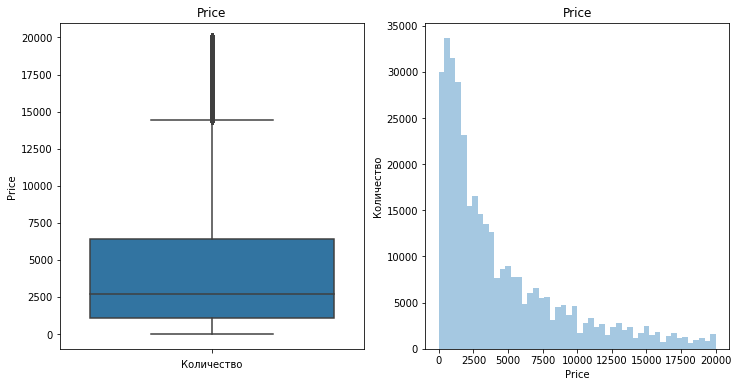

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('Price')
sns.boxplot(y = 'Price', data=data, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('Price')
sns.distplot(data['Price'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')

Text(0, 0.5, 'Количество')

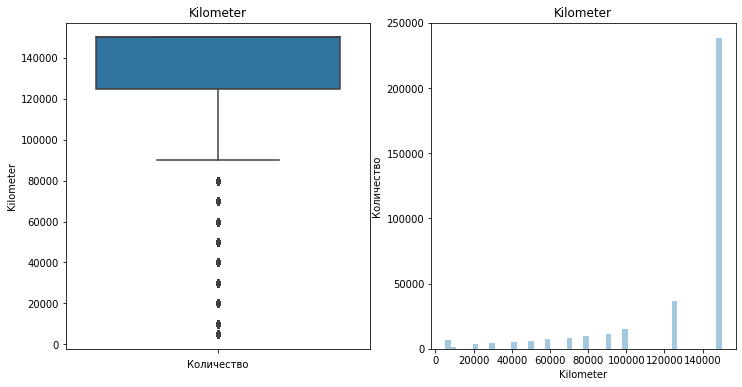

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('Kilometer')
sns.boxplot(y = 'Kilometer', data=data, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('Kilometer')
sns.distplot(data['Kilometer'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')

Приведем в порядок данные о годе регистрации, мощности, месяц. Так же есть данные, которые не представляют интереса в данном исследовании - выкинем их.

In [11]:
data = data.loc[(data['Price']>100)&(
    data['RegistrationMonth']!=0)&(data['Power']>50)&(data['Power']<300)&
                                              (data['RegistrationYear']>1980)&
                                              (data['RegistrationYear']<2019)]
data = data.drop(['NumberOfPictures','DateCrawled', 'DateCreated', 'LastSeen','PostalCode'], axis=1)

Заменим NaN на None

In [12]:
data=data.fillna('None')

Выделим каегорийные признаки

In [13]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired' ]

In [14]:
data.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

Преобразуем категорийные признаки в числовые значения

In [16]:
ordinalencoder = OrdinalEncoder()
data[cat_features] = ordinalencoder.fit_transform(data[cat_features])


Разделим анные на целевой признак и признаки

In [17]:
target = data['Price']
features = data.drop('Price', axis=1)

Разделим данные на обучающую, валидационую и тестовую выборки

In [20]:
features_train, features_ft, target_train, target_ft = train_test_split(    
    features, target, test_size=0.20, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(    
    features_ft, target_ft, test_size=0.5, random_state=12345)
print(len(features_train), len(features_ft), len(target_train), len(target_ft))
print(len(features_test), len(features_valid), len(target_test), len(target_valid))

217662 54416 217662 54416
27208 27208 27208 27208


## Обучение моделей

### Библиотека CatBoost

In [18]:

%%time
# обучим основываясь на библиотеке CatBoost
i = 0
result = pd.DataFrame(columns=['iteration','depth', 'learning_rate', 'rMSE'])
for iteration in range(20, 101, 10):
     for depth in range(1, 10, 2): 
        for learning_rate in np.arange(0.1, 1, 0.5):
            model = CatBoostRegressor(loss_function='RMSE', iterations=iteration , depth=depth, learning_rate=learning_rate)
            model.fit(features_train, target_train, cat_features=cat_features, verbose=False)
            pred_valid = model.predict(features_valid)
            result.loc[i] = [iteration, depth, learning_rate, mean_squared_error(target_valid, pred_valid)**0.5]
            i += 1
result.sort_values('rMSE').head(5)

CPU times: user 25min 57s, sys: 2min 37s, total: 28min 35s
Wall time: 30min 32s


,iteration,depth,learning_rate,rMSE
89,100.0,9.0,0.6,1538.453423
79,90.0,9.0,0.6,1544.073542
69,80.0,9.0,0.6,1548.240302
59,70.0,9.0,0.6,1552.537042
49,60.0,9.0,0.6,1555.728550


Обучим модель с оптимальными параметрами

In [19]:
%%time
model_cb = CatBoostRegressor(loss_function='RMSE', iterations=100 , depth=9, learning_rate=0.6)
model_cb.fit(features_train, target_train, cat_features=cat_features, verbose=False)
pred_valid_cb = model_cb.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_cb)**0.5
rmse

CPU times: user 45.2 s, sys: 4.68 s, total: 49.9 s
Wall time: 51.2 s


1546.6210456615263

### Библиотека LightGBM

In [20]:
%%time
# обучим основываясь на библиотеке lightGBM
i = 0
result = pd.DataFrame(columns=['max_depth','learning_rate', 'n_estimators', 'rMSE'])
for n_estimators in range(10, 101, 10):
     for max_depth in range(1, 10, 2): 
        for learning_rate in np.arange(0.1, 1, 0.2):
            model_lgb= lgb.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
            model_lgb.fit(features_train, target_train, categorical_feature=cat_features)
            pred_valid_lgb = model_lgb.predict(features_valid)
            result.loc[i] = [max_depth, learning_rate, n_estimators, mean_squared_error(target_valid, pred_valid_lgb)**0.5]
            i += 1
result.sort_values('rMSE').head(5)

CPU times: user 22min 47s, sys: 6.36 s, total: 22min 53s
Wall time: 23min 8s


,max_depth,learning_rate,n_estimators,rMSE
246,9.0,0.3,100.0,1518.244474
221,9.0,0.3,90.0,1527.160307
241,7.0,0.3,100.0,1531.655644
242,7.0,0.5,100.0,1534.387910
196,9.0,0.3,80.0,1536.283683


Обучим модель с оптимальными параметрами

In [21]:

%%time
# Обучим модель с оптимальными параметрами
model_lgb= lgb.LGBMRegressor(max_depth=7, learning_rate=0.3, n_estimators=100)
model_lgb.fit(features_train, target_train, categorical_feature=cat_features)
pred_valid_lgb = model_lgb.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_lgb)**0.5
rmse

CPU times: user 11.4 s, sys: 66.1 ms, total: 11.5 s
Wall time: 11.6 s


1552.9188307139982

### Обучающее дерево

In [22]:
%%time
# обучим основываясь на RandomForestRegressor
i = 0
result = pd.DataFrame(columns=['max_depth', 'n_estimators', 'rMSE'])
for n_estimators in range(10, 101, 10):
     for max_depth in range(1, 10, 2): 
        model_rfr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=12345)
        model_rfr.fit(features_train, target_train)
        pred_valid_rfr = model_rfr.predict(features_valid)
        result.loc[i] = [max_depth, n_estimators, mean_squared_error(target_valid, pred_valid_rfr)**0.5]
        i += 1
result.sort_values('rMSE').head(5)

CPU times: user 9min 50s, sys: 0 ns, total: 9min 50s
Wall time: 9min 54s


,max_depth,n_estimators,rMSE
29,9.0,60.0,1922.198641
34,9.0,70.0,1922.518998
39,9.0,80.0,1922.562120
49,9.0,100.0,1922.866449
44,9.0,90.0,1922.885802


Обучим модель с оптимальными параметрами

In [23]:
%%time
# Обучим модель с оптимальными параметрами
model_rfr = RandomForestRegressor(max_depth=9, n_estimators=50, random_state=12345)
model_rfr.fit(features_train, target_train)
pred_valid_rfr = model_rfr.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_rfr)**0.5
rmse

CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 18.2 s


1952.2973572599578

### Линейная регрессия

In [24]:
%%time
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
pred_valid_LR = model_LR.predict(features_test)
rmse = mean_squared_error(target_test, pred_valid_LR)**0.5
rmse

CPU times: user 92.9 ms, sys: 0 ns, total: 92.9 ms
Wall time: 56.8 ms


2961.2986352021053

## Анализ моделей

В результате работы был проведен анализ работы библиотек градиентного бустинга CatBoost, LightGBM и моделей линейной регресии и Случайного леса. Выявлена зависимость времени от качества предсказания. Самая быстрая модель - Линейная регрессия, она срабатывает за 57 мс, но RMSE самое высокое - 2961. Случайный лес работает 18 с с точностью 1952, еще 10 минут потребуется для подборки параметров. Библиотека LightGBM показывает результат 1552 за 12 с работы и 23 минуты подбора параметров. Наибольший результат показывает библиотека CatBoost. RMSE = 1546 при 51с работы и 30 минут подбора параметров.  
**Вывод**  
Наиболее оптимально в подобной задаче использовать библиотеку LightGBM, хотя если время расчета не приоритетно - CatBoost будет самой точной, но самой долгой.